In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import os
import scipy as sp
import xgboost as xgb
import lightgbm as lgb
import itertools
import operator
import math
import warnings
warnings.filterwarnings("ignore")
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint


goal = 'target'


Pretty printing has been turned OFF


In [8]:
# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")

# 导入数据

In [2]:
df_train = pd.read_table('../data/zhengqi_train.txt', sep='\t')
df_train.head(2)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.36,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.36,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676


In [3]:
df_test = pd.read_table('../data/zhengqi_test.txt', sep='\t')
df_test.head(2)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104


In [4]:
df_test["target"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0
dt = pd.concat([df_train, df_test], ignore_index=True)

# 加载数据

In [5]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [goal, 'isTrain']
    category_feature = []
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# 调参

## 迭代轮数确认

In [18]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
# # 忽略特征
# ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
#               # 证明是不重要的特征，XGB上放弃 
#               'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
#               'creatYearMonth_price', 'creatYearMonth_price_diff1']
# features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

cv_params = {
    'n_estimators':[1000, 2000, 3000, 5000],
#     'min_child_weight':[0.001, 0.1, 1,],
#     'boosting_type':['dart', 'gbtree'],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
#                 'n_estimators': 10, 
                'max_depth': 8, 
                'min_child_weight': 1, 
                'seed': 2020001,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
                'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用XGBoost建模...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   55.5s finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=8,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020001,
                                    silent=True, subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'n_estimators': [1000, 2000, 3000, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)


## min_child_weight与max_depth确认

In [19]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
# # 忽略特征
# ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
#               # 证明是不重要的特征，XGB上放弃 
#               'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
#               'creatYearMonth_price', 'creatYearMonth_price_diff1']
# features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

cv_params = {
#     'n_estimators':[1000, 2000, 3000, 5000],
    'min_child_weight':[5, 7, 9],
    'max_depth':[6, 7, 8],
#     'boosting_type':['dart', 'gbtree'],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 3000, 
#                 'max_depth': 8, 
#                 'min_child_weight': 1, 
                'seed': 2020001,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
                'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用XGBoost建模...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  1.5min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=3000, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020001,
                                    silent=True, subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [6, 7, 8], 'min_child_weight': [5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error

## gamma确认

In [21]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
# # 忽略特征
# ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
#               # 证明是不重要的特征，XGB上放弃 
#               'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
#               'creatYearMonth_price', 'creatYearMonth_price_diff1']
# features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

cv_params = {
#     'n_estimators':[1000, 2000, 3000, 5000],
#     'min_child_weight':[5, 7, 9],
#     'max_depth':[6, 7, 8],
    'gamma':[0, 0.001, 0.01, 0.1, 0.2],
#     'boosting_type':['dart', 'gbtree'],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 3000, 
                'max_depth': 8, 
                'min_child_weight': 7, 
                'seed': 2020001,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
#                 'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用XGBoost建模...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.9min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=8,
                                    min_child_weight=7, missing=None,
                                    n_estimators=3000, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020001,
                                    silent=True, subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'gamma': [0, 0.001, 0.01, 0.1, 0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)
参数的最

##  colsample_bytree与subsample参数确认

In [22]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
# # 忽略特征
# ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
#               # 证明是不重要的特征，XGB上放弃 
#               'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
#               'creatYearMonth_price', 'creatYearMonth_price_diff1']
# features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

cv_params = {
#     'n_estimators':[1000, 2000, 3000, 5000],
#     'min_child_weight':[5, 7, 9],
#     'max_depth':[6, 7, 8],
#     'gamma':[0, 0.001, 0.01, 0.1, 0.2],
    'subsample':[0.7, 0.8, 0.9],
    'colsample_bytree':[0.7, 0.75, 0.8, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 3000, 
                'max_depth': 8, 
                'min_child_weight': 7, 
                'seed': 2020001,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
                'gamma': 0.001, 
                'reg_alpha': 0, 
                'reg_lambda': 1
               }

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用XGBoost建模...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  5.1min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0.001, learning_rate=0.1,
                                    max_delta_step=0, max_depth=8,
                                    min_child_weight=7, missing=None,
                                    n_estimators=3000, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020001,
                                    silent=True, subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.7, 0.75, 0.8, 0.9],
                         'subsample': [0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fals

## reg_alpha与reg_lambda参数确认

In [23]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
# # 忽略特征
# ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
#               # 证明是不重要的特征，XGB上放弃 
#               'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
#               'creatYearMonth_price', 'creatYearMonth_price_diff1']
# features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

cv_params = {
#     'n_estimators':[1000, 2000, 3000, 5000],
#     'min_child_weight':[5, 7, 9],
#     'max_depth':[6, 7, 8],
#     'gamma':[0, 0.001, 0.01, 0.1, 0.2],
#     'subsample':[0.7, 0.8, 0.9],
#     'colsample_bytree':[0.7, 0.75, 0.8, 0.9],
    'reg_alpha': [0.01, 0.1, 0.2],
    'reg_lambda': [0.1, 0.3, 0.5, 0.7]    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 3000, 
                'max_depth': 8, 
                'min_child_weight': 7, 
                'seed': 2020001,
                'subsample': 0.8, 
                'colsample_bytree': 0.75, 
                'gamma': 0.001, 
#                 'reg_alpha': 0, 
#                 'reg_lambda': 1
               }

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_squared_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
=> 建模类别特征列： []
=> 使用XGBoost建模...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  5.3min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.75,
                                    gamma=0.001, learning_rate=0.1,
                                    max_delta_step=0, max_depth=8,
                                    min_child_weight=7, missing=None,
                                    n_estimators=3000, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=2020001,
                                    silent=True, subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [0.01, 0.1, 0.2],
                         'reg_lambda': [0.1, 0.3, 0.5, 0.7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

# 训练与分析

XGB交叉验证...
[0]	train-mae:0.74468	test-mae:0.74489
[500]	train-mae:0.060218	test-mae:0.205377
[1000]	train-mae:0.0282107	test-mae:0.20151
[1500]	train-mae:0.0140143	test-mae:0.200533
[2000]	train-mae:0.009227	test-mae:0.200279
[2500]	train-mae:0.00804133	test-mae:0.2002
[3000]	train-mae:0.00756367	test-mae:0.200147


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.75, gamma=0.001, learning_rate=0.01,
             max_delta_step=0, max_depth=8, min_child_weight=7, missing=None,
             n_estimators=3166, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1,
             seed=2020002, silent=True, subsample=0.8)

XGB训练...


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.75, gamma=0.001, learning_rate=0.01,
             max_delta_step=0, max_depth=8, min_child_weight=7, missing=None,
             n_estimators=3166, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1,
             seed=2020002, silent=True, subsample=0.8)

训练集MSE： 0.00010117741583718237
XGB迭代次数... 3166
XGB训练集预测...
XGB测试集预测...
XGB的特征重要性...


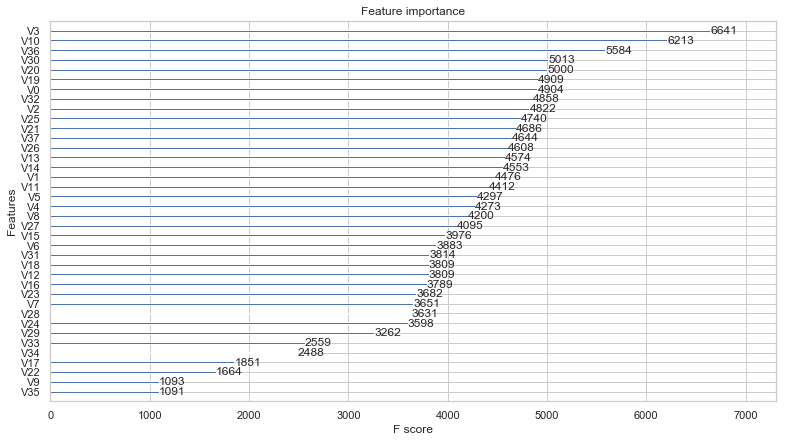

In [24]:
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')

xgbRegr = XGBRegressor(
    learning_rate =0.01,
    n_estimators=8000,
    max_depth = 8,
    min_child_weight=7,
    reg_alpha= 0.01,
    reg_lambda= 0.1,
    gamma=0.001,
    subsample=0.8,
    colsample_bytree=0.75,
    nthread=4,
    seed=2020002)
print('XGB交叉验证...')
xgb_param = xgbRegr.get_xgb_params()
dtrain = xgb.DMatrix(train[features], train[goal])
cvresult = xgb.cv(xgb_param, 
                  dtrain,
                  num_boost_round=xgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='mae',
                  early_stopping_rounds=50, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  shuffle=True)
xgbRegr.set_params(n_estimators=cvresult.shape[0])
print('XGB训练...')
xgbRegr.fit(train[features], train[goal], eval_metric='mae')
print('训练集MSE：', mean_squared_error(y_true=train[goal], y_pred=xgbRegr.predict(train[features])) )
print('XGB迭代次数...', xgbRegr.n_estimators)

print('XGB训练集预测...')
train_target_pre = xgbRegr.predict(train[features])

print('XGB测试集预测...')
test_target_pre = xgbRegr.predict(test[features])

#Plot feature importance 
print('XGB的特征重要性...')
plot_importance(xgbRegr)
plt.show()

# 去异常

In [10]:
def find_outlies(y_true, y_pre, train=train, sigma=3):
    diff = y_true-y_pre
    low_v = diff.quantile(sigma/100)
    up_v = diff.quantile(1-sigma/100)
    train = train[(diff>=low_v) & (diff<=up_v)]   
    return train
       

In [12]:
train = find_outlies(y_true=train.target, y_pre=train_target_pre, train=train, sigma=3)

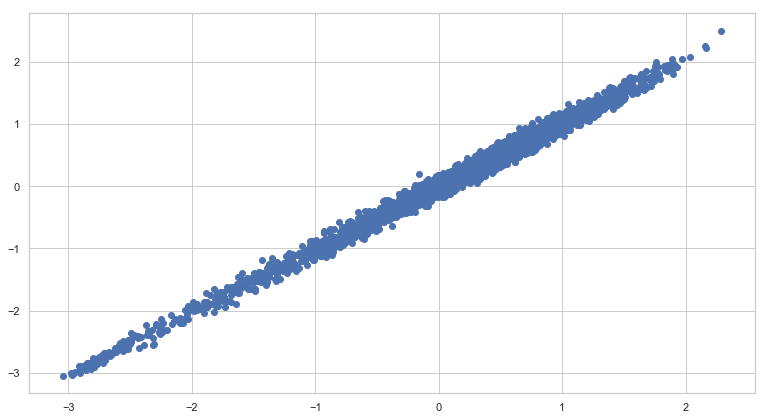

In [16]:
plt.scatter(train_target_pre, train.target)

# 返回调参重新训练

# 保存结果

In [25]:
submission = pd.DataFrame({goal: test_target_pre})
submission.to_csv("../result/sample_submit04-xxxx-xgb-delOutlies.txt", sep='\t', index=False, header=False)